In [32]:
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [33]:
model = Sequential([
    Conv2D(100, (3,3),activation='relu', input_shape = (150, 150, 3)),
    MaxPooling2D(2,2),
    
    Conv2D(100, (3,3),activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dropout(0.5),
    Dense(50, activation='relu'),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam',
loss = 'binary_crossentropy', metrics=['acc'])

In [34]:
TRAINING_DIR = "./Dataset/train"
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                              batch_size=10,
                                              target_size=(150, 150))
VALIDATION_DIR = "./Dataset/test"
validation_datagen = ImageDataGenerator(rescale=1.0/255)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                             batch_size = 10,
                                                             target_size=(150,150))

Found 1266 images belonging to 2 classes.
Found 194 images belonging to 2 classes.


In [45]:
DATA_DIR = './Dataset/train'
CATEGORIES = ['with_mask','without_mask']

IMG_SIZE = 150
train_data = []

for c in CATEGORIES:
    path = os.path.join(DATA_DIR, c)
    class_num = CATEGORIES.index(c)
    
    for img in  tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_COLOR)
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            train_data.append([img_resized, class_num])
        except Exception as e:
            pass
        
print(len(train_data))

100%|████████████████████████████████████████████████████████████████████████████████| 612/612 [00:12<00:00, 48.60it/s]

1266


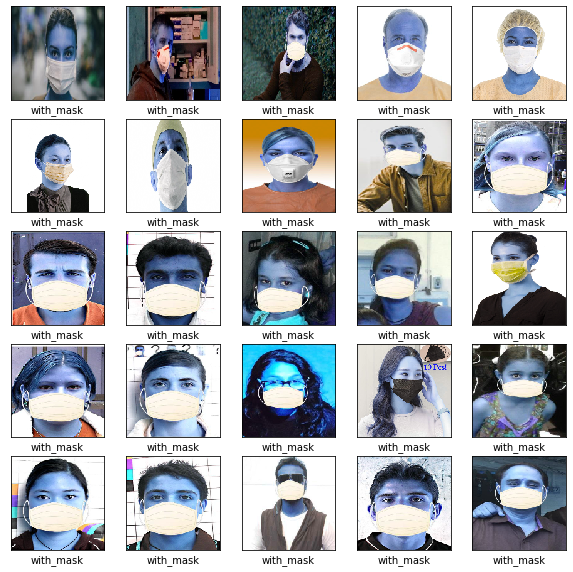

In [28]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_data[i][0])
    plt.xlabel(CATEGORIES[train_data[i][1]])
plt.show()

In [35]:
checkpoint = ModelCheckpoint('model2-{epoch:03d}.model',
                             monitor='val_loss',
                             verbose=0,
                             save_best_only=True,
                             mode='auto')

In [36]:
history = model.fit_generator(train_generator,
                              epochs=10,
                              validation_data=validation_generator,
                              callbacks=[checkpoint])

Epoch 1/10
127/127 [==============================] - ETA: 0s - loss: 0.6699 - acc: 0.6682WARNING:tensorflow:From C:\Users\User\anaconda3\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model2-001.model\assets
127/127 [==============================] - 158s 1s/step - loss: 0.6699 - acc: 0.6682 - val_loss: 0.3548 - val_acc: 0.8814
Epoch 2/10
127/127 [==============================] - 151s 1s/step - loss: 0.3631 - acc: 0.8728 - val_loss: 0.1595 - val_acc: 0.9278
Epoch 3/10
127/127 [==============================] - 149s 1s/step - loss: 0.2988 - acc: 0.8886 - val_loss: 0.1047 - val_

In [44]:
import cv2
import numpy as np
from keras.models import load_model
model = load_model("./model2-010.model")

results={0:'without mask',1:'mask'}
GR_dict={0:(0,0,255),1:(0,255,0)}

rect_size = 4
cap = cv2.VideoCapture(0) 


haarcascade = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')

while True:
    (rval, im) = cap.read()
    im=cv2.flip(im,1,1) 

    
    rerect_size = cv2.resize(im, (im.shape[1] // rect_size, im.shape[0] // rect_size))
    faces = haarcascade.detectMultiScale(rerect_size)
    for f in faces:
        (x, y, w, h) = [v * rect_size for v in f] 
        
        face_img = im[y:y+h, x:x+w]
        rerect_sized=cv2.resize(face_img,(150,150))
        normalized=rerect_sized/255.0
        reshaped=np.reshape(normalized,(1,150,150,3))
        reshaped = np.vstack([reshaped])
        result=model.predict(reshaped)

        
        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(im,(x,y),(x+w,y+h),GR_dict[label],2)
        cv2.rectangle(im,(x,y-40),(x+w,y),GR_dict[label],-1)
        cv2.putText(im, results[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)

    cv2.imshow('LIVE',   im)
    key = cv2.waitKey(10)
    
    if key == 27: 
        break

cap.release()

cv2.destroyAllWindows()